In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import descartes
import shapely.wkt
import pyproj

from shapely.geometry import Point

## Enunciado

A partir do conjunto de dados resultante do TP1 vamos construir um modelo de regressão
linear que estima o preço por m2 dos imóveis.
O modelo pode ser construído envolvendo apenas um subconjunto do conjunto de dados
limpo, com algumas características particulares. Por exemplo, apenas apartamentos nos
bairros de Belgrano e Palermo ou apenas PHs no bairro de Almagro e Villa Crespo, ou
apenas propriedades industriais em Pompeya. O conjunto de dados que eles modelam deve
ter pelo menos 2.000 registros.

##### Objetivos:
* Selecione os dados para modelar. Justifique essa escolha.
* Treine pelo menos três modelos de regressão linear diferentes nesses dados.
* Avalie o desempenho dos modelos e compare vantagens e desvantagens de cada um.
* Determine a importância dos recursos incluídos na previsão. Interpretar.

### Importando as bases de dados 

* Base de dados dos Imóveis: 

In [2]:
prop = pd.read_csv(r"C:\Users\RedRagon\Documents\ProjetoIntegrador1\Data\Real_State_Properati.csv",sep='\t')

In [3]:
prop.shape

(17223, 9)

In [4]:
prop.head(5)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0
2,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,138000.0,USD,45.0
3,apartment,Belgrano,Argentina,Capital Federal,-34.559873,-58.443362,195000.0,USD,65.0
4,PH,Mataderos,Argentina,Capital Federal,-34.652356,-58.501624,239000.0,USD,140.0


* Base de dados dos bairros:

In [5]:
df_bairros = pd.read_csv("Data/Neighborhoods.csv", encoding = 'latin1')
df_bairros.head()

,WKT,NEIGHBORHOOD,COMMUNE,PERIMETER,AREA
0,"POLYGON ((-58.4528200492791 -34.5959886570639,...",CHACARITA,15.0,7725.695228,3.118101e+06
1,"POLYGON ((-58.4655768128541 -34.5965577078058,...",PATERNAL,15.0,7087.513295,2.229829e+06
2,"POLYGON ((-58.4237529813037 -34.5978273383243,...",VILLA CRESPO,15.0,8132.699348,3.613584e+06
3,"POLYGON ((-58.4946097568899 -34.6148652395239,...",VILLA DEL PARQUE,11.0,7705.389797,3.399596e+06
4,"POLYGON ((-58.4128700313089 -34.6141162515854,...",ALMAGRO,5.0,8537.901368,4.050752e+06


* Base de dados das estações de metrô:

In [6]:
df_metros = pd.read_csv('Data/estaciones-de-subte.csv',sep=',')
df_metros.head()

,long,lat,id,estacion,linea
0,-58.398928,-34.635750,1.0,CASEROS,H
1,-58.400970,-34.629376,2.0,INCLAN - MEZQUITA AL AHMAD,H
2,-58.402323,-34.623092,3.0,HUMBERTO 1°,H
3,-58.404732,-34.615242,4.0,VENEZUELA,H
4,-58.406036,-34.608935,5.0,ONCE - 30 DE DICIEMBRE,H


### Verificando se há algum valor nulo

In [7]:
prop.isna().sum()

property_type          0
place_name             0
country_name           0
state_name             0
lat                    0
lon                    0
price                  0
currency               0
surface_total_in_m2    0
dtype: int64

### Limpando o dataset 

In [8]:
prop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17223 entries, 0 to 17222
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   property_type        17223 non-null  object 
 1   place_name           17223 non-null  object 
 2   country_name         17223 non-null  object 
 3   state_name           17223 non-null  object 
 4   lat                  17223 non-null  float64
 5   lon                  17223 non-null  float64
 6   price                17223 non-null  float64
 7   currency             17223 non-null  object 
 8   surface_total_in_m2  17223 non-null  float64
dtypes: float64(4), object(5)
memory usage: 1.2+ MB


In [9]:
for col in prop.columns:
    print(col, "-", len(prop[col].unique()))

property_type - 4
place_name - 62
country_name - 1
state_name - 1
lat - 9714
lon - 9704
price - 2754
currency - 2
surface_total_in_m2 - 568


In [10]:
prop['property_type'].unique()

array(['PH', 'apartment', 'house', 'store'], dtype=object)

In [11]:
prop.groupby(by = 'property_type').count()['place_name'].sort_values(ascending = False)

property_type
apartment    14428
PH            1142
house          888
store          765
Name: place_name, dtype: int64

In [12]:
prop['property_type'].value_counts()/len(prop['property_type'])*100

apartment    83.771701
PH            6.630668
house         5.155896
store         4.441735
Name: property_type, dtype: float64

In [13]:
prop.groupby(by = 'currency').count()['place_name'].sort_values(ascending = False)

currency
USD    16700
ARS      523
Name: place_name, dtype: int64

In [14]:
prop['currency'].value_counts()/len(prop['currency'])*100

USD    96.963363
ARS     3.036637
Name: currency, dtype: float64

In [15]:
prop["price_usd"] = prop.apply(lambda x: x["price"] if x["currency"] == "USD" else x["price"]/117.41,axis=1)

In [16]:
prop.columns

Index(['property_type', 'place_name', 'country_name', 'state_name', 'lat',
       'lon', 'price', 'currency', 'surface_total_in_m2', 'price_usd'],
      dtype='object')

In [17]:
prop["preco_metro2"] = prop.price_usd / prop.surface_total_in_m2

In [18]:
prop['Faixas_de_preco_m2'] = pd.qcut(x = prop.preco_metro2, q = 10, labels = [1,2,3,4,5,6,7,8,9,10])

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\numpy\lib\function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


In [19]:
prop.shape

(17223, 12)

In [20]:
prop[(prop.property_type == 'apartment') & (prop.surface_total_in_m2 == 0)]

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_usd,preco_metro2,Faixas_de_preco_m2
2486,apartment,Palermo Soho,Argentina,Capital Federal,-34.589974,-58.425614,780000.0,USD,0.0,780000.0,inf,10
4872,apartment,Recoleta,Argentina,Capital Federal,-34.588818,-58.390648,320000.0,USD,0.0,320000.0,inf,10
5454,apartment,Caballito,Argentina,Capital Federal,-34.617348,-58.449404,68500.0,USD,0.0,68500.0,inf,10
6318,apartment,Palermo Hollywood,Argentina,Capital Federal,-34.582558,-58.432585,175000.0,USD,0.0,175000.0,inf,10
7170,apartment,Barracas,Argentina,Capital Federal,-34.641131,-58.369122,135000.0,USD,0.0,135000.0,inf,10
15888,apartment,Barrio Norte,Argentina,Capital Federal,-34.598727,-58.395851,112000.0,USD,0.0,112000.0,inf,10


In [21]:
prop.drop(index = list(prop[(prop.property_type == 'apartment') & (prop.surface_total_in_m2 == 0)].index),inplace = True)

In [22]:
for i in prop.property_type.unique():
    prop.drop(index = list(prop.loc[(prop.property_type == i) & (prop.preco_metro2 > 3*prop.preco_metro2.std())].index), inplace = True)

In [23]:
prop.columns

Index(['property_type', 'place_name', 'country_name', 'state_name', 'lat',
       'lon', 'price', 'currency', 'surface_total_in_m2', 'price_usd',
       'preco_metro2', 'Faixas_de_preco_m2'],
      dtype='object')

In [24]:
prop.shape

(16770, 12)

### Plotando o mapa de buenos aires com divisória de bairros para saber o preço médio quadrado de cada bairro

In [25]:
df_bairros["WKT"] = df_bairros["WKT"].apply(shapely.wkt.loads)
geo_bairros = gpd.GeoDataFrame(df_bairros, geometry = 'WKT' )
type(geo_bairros)

geopandas.geodataframe.GeoDataFrame

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])


<AxesSubplot:>

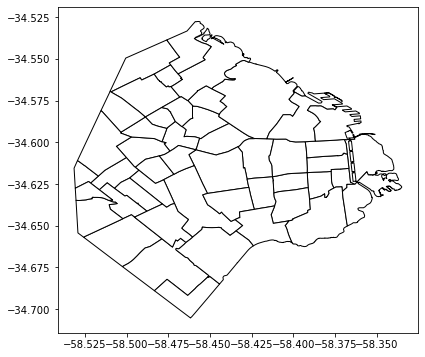

In [26]:
geo_bairros.plot(color = 'white', edgecolor='black', figsize=(10,6))

In [27]:
geometria = gpd.points_from_xy(prop['lon'],prop['lat'])

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\geopandas\array.py:253: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


In [28]:
prop = gpd.GeoDataFrame(prop,
                        geometry = geometria
                        )

In [29]:
prop.loc[ : , ['geometry', 'lat', 'lon', 'property_type', 'place_name']]

,geometry,lat,lon,property_type,place_name
0,POINT (-58.50884 -34.66182),-34.661824,-58.508839,PH,Mataderos
1,POINT (-58.52298 -34.65226),-34.652262,-58.522982,apartment,Mataderos
2,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
3,POINT (-58.44336 -34.55987),-34.559873,-58.443362,apartment,Belgrano
4,POINT (-58.50162 -34.65236),-34.652356,-58.501624,PH,Mataderos
...,...,...,...,...,...
17218,POINT (-58.40252 -34.59921),-34.599214,-58.402519,apartment,Barrio Norte
17219,POINT (-58.39737 -34.58743),-34.587425,-58.397372,apartment,Recoleta
17220,POINT (-58.44268 -34.56369),-34.563685,-58.442683,apartment,Belgrano
17221,POINT (-58.44268 -34.56369),-34.563685,-58.442683,apartment,Belgrano


In [30]:
prop['property_place'] = prop['property_type'] + '_' + prop['place_name']

In [31]:
prop['avg_price_m2'] = prop.groupby('property_place')['preco_metro2'].transform('mean')

In [32]:
prop.head(2)

,property_type,place_name,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_usd,preco_metro2,Faixas_de_preco_m2,geometry,property_place,avg_price_m2
0,PH,Mataderos,Argentina,Capital Federal,-34.661824,-58.508839,62000.0,USD,55.0,62000.0,1127.272727,1,POINT (-58.50884 -34.66182),PH_Mataderos,1386.591733
1,apartment,Mataderos,Argentina,Capital Federal,-34.652262,-58.522982,72000.0,USD,55.0,72000.0,1309.090909,2,POINT (-58.52298 -34.65226),apartment_Mataderos,1776.706933


C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\descartes\patch.py:62: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  vertices = concatenate([
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\descartes\patch.py:64: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  [asarray(r)[:, :2] for r in t.interiors])
C:\U

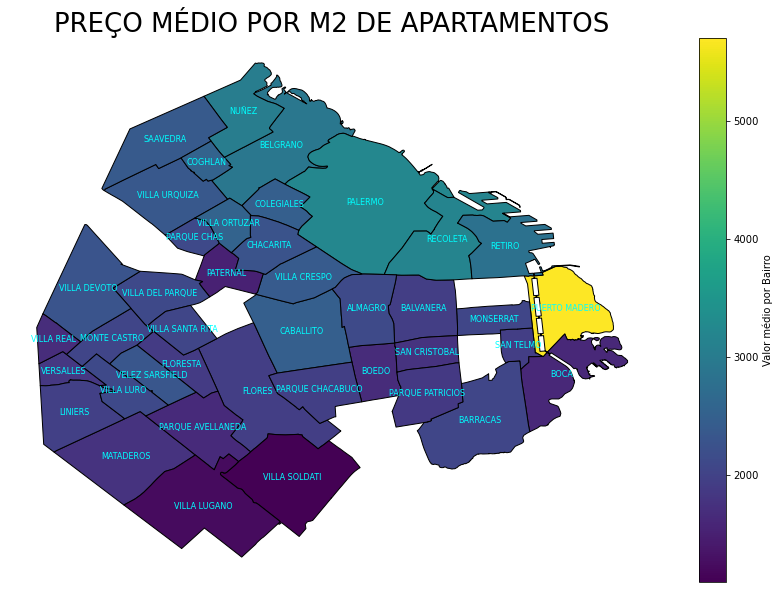

In [33]:
df_apart = prop.loc[ : , ['property_type', 'place_name', 'avg_price_m2']]

avg_bairro_apart = df_apart.loc[df_apart['property_type'] == 'apartment']
avg_bairro_apart['place_name'] = avg_bairro_apart['place_name'].str.upper()

geodata_apart = pd.merge(left=avg_bairro_apart, right=df_bairros, left_on='place_name', right_on='NEIGHBORHOOD', how='inner')
geodata_apart = geodata_apart.rename(columns={"WKT": "geometry"})
geodata_apart = geodata_apart.drop(columns=['NEIGHBORHOOD','COMMUNE','PERIMETER','AREA'])
geodata_apart = geodata_apart.drop_duplicates(subset=['place_name'])

geodf_apart = gpd.GeoDataFrame(geodata_apart)

ax = geodf_apart.loc[geodf_apart['property_type'] == 'apartment'].plot(
    figsize=(15,10),
    edgecolor='black',column='avg_price_m2',
    legend=True,
    legend_kwds={'label': "Valor médio por Bairro",'orientation':"vertical" })

for i in geodf_apart.index:
    plt.text(geodf_apart.geometry.centroid[i].coords[0][0], geodf_apart.geometry.centroid[i].coords[0][1], geodf_apart.place_name[i],
             fontsize=8, horizontalalignment='center', verticalalignment='center', color = 'cyan')
    
ax.set_axis_off();
ax.set_title("PREÇO MÉDIO POR M2 DE APARTAMENTOS",fontsize=26);

Com base nesse mapa vemos que tem um bairro muito caro pra se morar (Puerto Madero) e vários outros na média e outros baratos. Também, enquanto limpavamos o dataset, verificamos que possui muitos apartamentos, com isso decidimos pegar apartamento, por isso plotamos o mapa em função do preço médio quadrado de apartamento.
Também decidimos pegar os bairros: Retiro, Recoleta, Palermo, Belgrano, Nuñez, por conta de que eles estão na média de preço por metro quadrado dos bairros, não está tão caro nem está tão barato.

<div class="alert alert-block alert-warning">
    <b>prop.groupby(by = 'property_type').count()['place_name'].sort_values(ascending = False)

property_type
        
apartment    14428
        
PH            1142
        
house          888
        
store          765
    </b>
</div>

### Fazendo dummies dos bairros e das faixas de preço e dropando colunas que não iremos usar

Vamos ver a correlação entre as variáveis

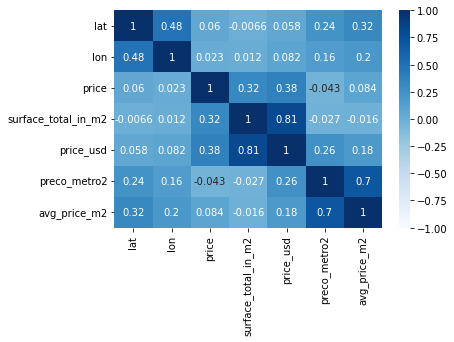

In [34]:
sns.heatmap(prop.corr(), 
            annot = True, 
            vmin = -1, 
            cmap = 'Blues'
            );


Faremos um filtro pra ficar com um dataframe e pegar os bairros que escolhemos, além de que como os bairros são importantes para usar no modelo por causa que dependendo do bairro o preço vai ser mais caro ou não, faremos dummies da coluna de bairros para utilizar no modelo de regressão.

In [35]:
aa = prop[prop.place_name == 'Retiro']
a = aa[aa.property_type == 'apartment']
bb = prop[prop.place_name == 'Recoleta']
b = bb[bb.property_type == 'apartment']
cc = prop[prop.place_name == 'Palermo']
c = cc[cc.property_type == 'apartment']
dd = prop[prop.place_name == 'Belgrano']
d = dd[dd.property_type == 'apartment']
ee = prop[prop.place_name == 'Nuñez']
e = ee[ee.property_type == 'apartment']
df_analise = pd.concat([a,b,c,d,e])
df212 = df_analise.sort_values(by='place_name')
dummiess = pd.get_dummies(df212.place_name)
data22 = pd.concat([df212, dummiess],axis=1)
data = data22.drop(columns = ['place_name'])
dumies = pd.get_dummies(data.property_type)
df = pd.concat([data,dumies],axis =1)
df = df.drop(columns = ['property_type','apartment'])
df.head()

,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_usd,preco_metro2,Faixas_de_preco_m2,geometry,property_place,avg_price_m2,Belgrano,Nuñez,Palermo,Recoleta,Retiro
10106,Argentina,Capital Federal,-34.55527,-58.455786,180000.0,USD,77.0,180000.0,2337.662338,5,POINT (-58.45579 -34.55527),apartment_Belgrano,2921.998257,1,0,0,0,0
11109,Argentina,Capital Federal,-34.56021,-58.469261,210000.0,USD,111.0,210000.0,1891.891892,3,POINT (-58.46926 -34.56021),apartment_Belgrano,2921.998257,1,0,0,0,0
11110,Argentina,Capital Federal,-34.56021,-58.469261,114210.0,USD,42.0,114210.0,2719.285714,7,POINT (-58.46926 -34.56021),apartment_Belgrano,2921.998257,1,0,0,0,0
11112,Argentina,Capital Federal,-34.56021,-58.469261,230000.0,USD,98.0,230000.0,2346.938776,5,POINT (-58.46926 -34.56021),apartment_Belgrano,2921.998257,1,0,0,0,0
11113,Argentina,Capital Federal,-34.56021,-58.469261,263000.0,USD,113.0,263000.0,2327.433628,5,POINT (-58.46926 -34.56021),apartment_Belgrano,2921.998257,1,0,0,0,0


Vamos ver o ajuste de regressão para ver oq está impactando mais.

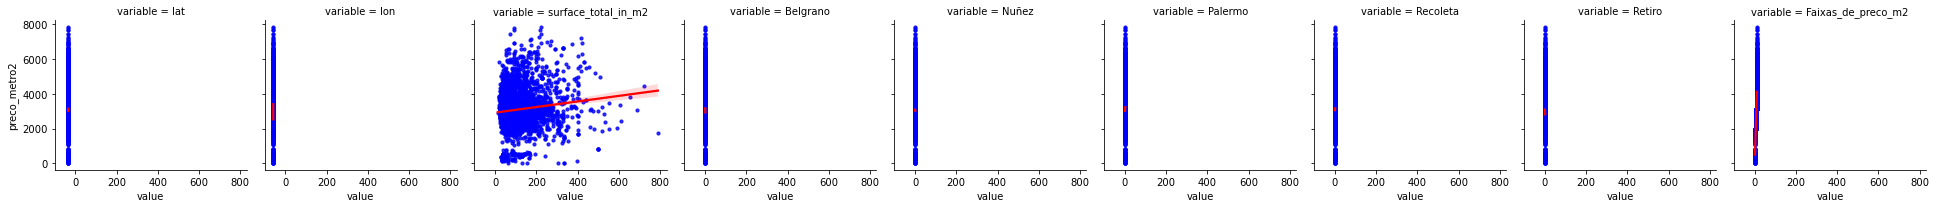

In [36]:
df_grid = pd.melt(df, id_vars = 'preco_metro2', value_vars = ['lat', 'lon', 'surface_total_in_m2','Belgrano', 'Nuñez', 'Palermo', 'Recoleta', 'Retiro','Faixas_de_preco_m2'])
g = sns.FacetGrid(df_grid, col = "variable")
g.map(sns.regplot, "value", "preco_metro2", ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"});

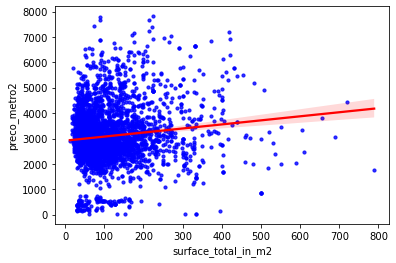

In [37]:
sns.regplot(data = df, x = "surface_total_in_m2", y = "preco_metro2", ci = 95, scatter_kws = {"color": "blue", 's': 10}, line_kws = {"color": "red"});

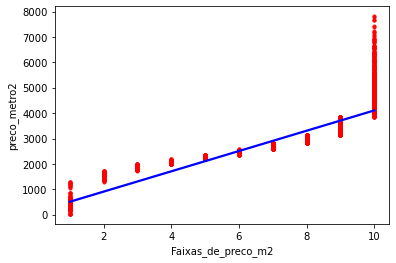

In [38]:
sns.regplot(data = df, x = "Faixas_de_preco_m2", y = "preco_metro2", ci = 95, scatter_kws = {"color": "red", 's': 10}, line_kws = {"color": "blue"});

Vemos que faixas de preço ta meio estranho, por isso vamos fazer dummies para usar cada faixa de valor como feature.

In [39]:
dum = pd.get_dummies(df.Faixas_de_preco_m2)
df = pd.concat([df,dum],axis=1)
df

,country_name,state_name,lat,lon,price,currency,surface_total_in_m2,price_usd,preco_metro2,Faixas_de_preco_m2,...,1,2,3,4,5,6,7,8,9,10
10106,Argentina,Capital Federal,-34.555270,-58.455786,180000.0,USD,77.0,180000.0,2337.662338,5,...,0,0,0,0,1,0,0,0,0,0
11109,Argentina,Capital Federal,-34.560210,-58.469261,210000.0,USD,111.0,210000.0,1891.891892,3,...,0,0,1,0,0,0,0,0,0,0
11110,Argentina,Capital Federal,-34.560210,-58.469261,114210.0,USD,42.0,114210.0,2719.285714,7,...,0,0,0,0,0,0,1,0,0,0
11112,Argentina,Capital Federal,-34.560210,-58.469261,230000.0,USD,98.0,230000.0,2346.938776,5,...,0,0,0,0,1,0,0,0,0,0
11113,Argentina,Capital Federal,-34.560210,-58.469261,263000.0,USD,113.0,263000.0,2327.433628,5,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9444,Argentina,Capital Federal,-34.597040,-58.378666,199555.0,USD,52.0,199555.0,3837.596154,9,...,0,0,0,0,0,0,0,0,1,0
9582,Argentina,Capital Federal,-34.586849,-58.384689,470000.0,USD,161.0,470000.0,2919.254658,8,...,0,0,0,0,0,0,0,1,0,0
9919,Argentina,Capital Federal,-34.592865,-58.381134,500000.0,USD,166.0,500000.0,3012.048193,8,...,0,0,0,0,0,0,0,1,0,0
10455,Argentina,Capital Federal,-34.591852,-58.376688,230000.0,USD,70.0,230000.0,3285.714286,9,...,0,0,0,0,0,0,0,0,1,0


In [40]:
df.columns

Index([       'country_name',          'state_name',                 'lat',
                       'lon',               'price',            'currency',
       'surface_total_in_m2',           'price_usd',        'preco_metro2',
        'Faixas_de_preco_m2',            'geometry',      'property_place',
              'avg_price_m2',            'Belgrano',               'Nuñez',
                   'Palermo',            'Recoleta',              'Retiro',
                           1,                     2,                     3,
                           4,                     5,                     6,
                           7,                     8,                     9,
                          10],
      dtype='object')




Droparemos o que não vamos usar.

In [41]:
df = df.drop(columns = ['country_name','state_name','price','currency','price_usd','Faixas_de_preco_m2',
                        'geometry','property_place','avg_price_m2'])
df

,lat,lon,surface_total_in_m2,preco_metro2,Belgrano,Nuñez,Palermo,Recoleta,Retiro,1,2,3,4,5,6,7,8,9,10
10106,-34.555270,-58.455786,77.0,2337.662338,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
11109,-34.560210,-58.469261,111.0,1891.891892,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
11110,-34.560210,-58.469261,42.0,2719.285714,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
11112,-34.560210,-58.469261,98.0,2346.938776,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
11113,-34.560210,-58.469261,113.0,2327.433628,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9444,-34.597040,-58.378666,52.0,3837.596154,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
9582,-34.586849,-58.384689,161.0,2919.254658,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
9919,-34.592865,-58.381134,166.0,3012.048193,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
10455,-34.591852,-58.376688,70.0,3285.714286,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0


### Nova coluna da distância do apartamento até a estação de metrô mais próximo

In [42]:
df_metros = df_metros.rename(columns={'long':'lon','estacion':'estação'})
df_metros = df_metros.drop(columns=['id','linea'])
df_metros

,lon,lat,estação
0,-58.398928,-34.635750,CASEROS
1,-58.400970,-34.629376,INCLAN - MEZQUITA AL AHMAD
2,-58.402323,-34.623092,HUMBERTO 1°
3,-58.404732,-34.615242,VENEZUELA
4,-58.406036,-34.608935,ONCE - 30 DE DICIEMBRE
...,...,...,...
85,-58.402376,-34.594525,SANTA FE - CARLOS JAUREGUI
86,-58.391019,-34.583036,FACULTAD DE DERECHO - JULIETA LANTERI
87,-58.375850,-34.592114,RETIRO
88,-58.371700,-34.596597,CATALINAS


Vamos fazer uma nova coluna da distância entre o apartamento até o metrô mais próximo.

In [43]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import geopy.distance

for x in df.index:
    ponto = (df['lon'][x], df['lat'][x])
    df.loc[x, 'distância até o metrô'] = min([geopy.distance.geodesic(ponto,(row.lon,row.lat)).meters for index, row in df_metros.iterrows()])

In [44]:
df.head()

,lat,lon,surface_total_in_m2,preco_metro2,Belgrano,Nuñez,Palermo,Recoleta,Retiro,1,2,3,4,5,6,7,8,9,10,distância até o metrô
10106,-34.55527,-58.455786,77.0,2337.662338,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,418.340602
11109,-34.56021,-58.469261,111.0,1891.891892,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,811.707924
11110,-34.56021,-58.469261,42.0,2719.285714,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,811.707924
11112,-34.56021,-58.469261,98.0,2346.938776,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,811.707924
11113,-34.56021,-58.469261,113.0,2327.433628,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,811.707924


### Aplicando Modelo de Regressão Linear Múltipla

In [170]:
import random
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
  
random.seed(3)
feature_cols = ['lat',                   'lon',
         'surface_total_in_m2',              'Belgrano',
                      'Nuñez',
                     'Palermo',              'Recoleta',
                      'Retiro',                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10, 'distância até o metrô']
X = df[feature_cols]
y = df.preco_metro2

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 42)
y_pred = model.predict(X_test)

lr = linear_model.LinearRegression()
cv = KFold(5, 
           shuffle = True
          )
scores = cross_val_score(lr, 
                         X_train, 
                         y_train, 
                         cv = cv, 
                         scoring = 'r2'
                        )
scores, scores.mean()

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature name

(array([0.88662505, 0.88334704, 0.89978271, 0.88249908, 0.91546885]),
 0.8935445472227451)

In [167]:
y_pred = model.predict(X_test)
y_pred

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([4889.88818551, 2802.36408075, 2935.24955428, ..., 4765.41373753,
       2445.70850514, 3354.30273112])

In [168]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
print ('MAE:', mean_absolute_error(y_test, y_pred).round(2))
print ('MSE:', mean_squared_error(y_test, y_pred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)).round(2))
print ('R2:', r2_score(y_test, y_pred).round(2))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred).round(2))

MAE: 198.74
MSE: 129186.25
RMSE: 359.42
R2: 0.89
MAPE 0.11


---

In [156]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model
feature_cols = ['lat',                   'lon',
         'surface_total_in_m2',              'Belgrano',
                      'Nuñez',
                     'Palermo',              'Recoleta',
                      'Retiro',                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10, 'distância até o metrô']

In [157]:
X = df[feature_cols]
y = df['preco_metro2']

print("Shape X:", X.shape)
print("Type X:", type(X))
print("Shape y:", y.shape)
print("Type y:", type(y))

Shape X: (4073, 19)
Type X: <class 'pandas.core.frame.DataFrame'>
Shape y: (4073,)
Type y: <class 'pandas.core.series.Series'>


In [158]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state = 1
                                                   )
model.fit(X_train,y_train)

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


LinearRegression()

In [159]:
model.coef_

array([ 2.12541648e+03,  8.53552438e+02,  6.73685527e-01, -1.32744327e+01,
        1.57748102e+00,  4.24154536e+01, -3.86304148e+01,  7.91191290e+00,
       -1.95755637e+03, -9.49785736e+02, -6.15016378e+02, -3.81173502e+02,
       -1.63082543e+02,  2.55846755e+01,  2.39216505e+02,  5.20873627e+02,
        9.80344911e+02,  2.30059481e+03,  4.43974765e-03])

In [160]:
model.intercept_

125753.57924141317

In [161]:
model.predict(X)

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([2291.53461134, 1842.25102681, 2649.99960813, ..., 3040.32690731,
       3439.75741783, 2944.33904124])

In [162]:
test_sklearn = np.array(X_test)
model.predict(test_sklearn)

array([3374.44961848,  468.04631963, 2282.36953027, ..., 2646.07330956,
       2436.24111581, 2710.2205498 ])

In [163]:
y_pred = model.predict(X_test)
y_pred

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([3374.44961848,  468.04631963, 2282.36953027, ..., 2646.07330956,
       2436.24111581, 2710.2205498 ])

In [164]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
print ('MAE:', mean_absolute_error(y_test, y_pred).round(2))
print ('MSE:', mean_squared_error(y_test, y_pred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)).round(2))
print ('R2:', r2_score(y_test, y_pred).round(2))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred).round(2))

MAE: 194.09
MSE: 118385.24
RMSE: 344.07
R2: 0.89
MAPE 0.1


In [165]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [53]:
feature_cols = ['lat',                   'lon',
         'surface_total_in_m2',              'Belgrano',
                      'Nuñez',
                     'Palermo',              'Recoleta',
                      'Retiro',                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10, 'distância até o metrô']

X = df[feature_cols]
y = df.preco_metro2

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1)
y_train = y_train.astype('int')

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2851, 19)
(1222, 19)
(2851,)
(1222,)


In [55]:
gnb = GaussianNB()

gnb

GaussianNB()

In [56]:
gnb.fit(X_train, y_train)

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


GaussianNB()

In [57]:
y_pred = gnb.predict(X_test)

y_pred

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([3781,  510, 2317, ..., 3957, 3591, 2470])

In [58]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
print ('MAE:', mean_absolute_error(y_test, y_pred).round(2))
print ('MSE:', mean_squared_error(y_test, y_pred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)).round(2))
print ('R2:', r2_score(y_test, y_pred).round(2))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred).round(2))

MAE: 199.79
MSE: 150272.87
RMSE: 387.65
R2: 0.86
MAPE 0.08


### Regressão Lasso

In [150]:
# Ajustamos o modelo usando somente as variables quantitativas e MCO
feature_cols = ['lat',                   'lon',
         'surface_total_in_m2',              'Belgrano',
                      'Nuñez',
                     'Palermo',              'Recoleta',
                      'Retiro',                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10, 'distância até o metrô']
X = df[feature_cols]
y = df['preco_metro2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, 
                                                    random_state = 42
                                                   )
y_pred = model.predict(X_test)
y_pred

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([4889.88818551, 2802.36408075, 2935.24955428, ..., 3617.37165826,
       3413.48454647, 3415.23514164])

In [155]:
lm_lasso = linear_model.LassoCV(alphas = [0,0.025,0.5],
                                normalize = True, 
                                cv = 3
                               )

model_5 = lm_lasso.fit(X_train, y_train)

print('Score Lasso:', model_5.score(X_test, y_test))

Score Lasso: 0.8877122185958805


C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: UserWarning: Coordinate descent without L1 regularization may lead to unexpected results and is discouraged. Set l1_ratio > 0 to add L1 regularization.
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 98999966.79249859, tolerance: 192078.44368758638
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\lin

In [152]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
print ('MAE:', mean_absolute_error(y_test, y_pred).round(2))
print ('MSE:', mean_squared_error(y_test, y_pred).round(2))
print ('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)).round(2))
print ('R2:', r2_score(y_test, y_pred).round(2))
print('MAPE', mean_absolute_percentage_error(y_test, y_pred).round(2))

MAE: 199.15
MSE: 132071.66
RMSE: 363.42
R2: 0.89
MAPE 0.1


### Regressão Ridge CV

In [147]:
feature_cols = ['lat',                   'lon',
         'surface_total_in_m2',              'Belgrano',
                      'Nuñez',
                     'Palermo',              'Recoleta',
                      'Retiro',                       1,
                             2,                       3,
                             4,                       5,
                             6,                       7,
                             8,                       9,
                            10, 'distância até o metrô']
X = df[feature_cols]
y = df['preco_metro2']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.35, 
                                                    random_state = 42
                                                   )
y_pred = model.predict(X_test)
y_pred

C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


array([4889.88818551, 2802.36408075, 2935.24955428, ..., 3617.37165826,
       3413.48454647, 3415.23514164])

In [154]:

lm_ridge = linear_model.RidgeCV(alphas = [0.1, 1, 10], 
                                normalize = True
                               ) 

model_2 = lm_ridge.fit(X_train, y_train)

print('Score Ridge CV:', model_2.score(X_test, y_test))


Score Ridge CV: 0.8788085331792912


C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\linear_model\_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), _RidgeGCV())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alphas to: original_alphas * n_samples. 
  warnings.warn(
C:\Users\RedRagon\anaconda3\envs\ProjetoIntegrador2\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(